### Sagemaker built-in Training and Deployment with LinearLearner

In this notebook, we use Sagemaker's built-in machine learning model __LinearLearner__ to predict the __log_votes__ field of our review dataset.

* Find more details on the Sagemaker's __LinearLearner__ here: https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)


### 1. Reading the dataset

We will use the __pandas__ library to read our dataset.

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

import pandas as pd

df = pd.read_csv('../../DATA/NLP/EMBK-NLP-REVIEW-DATA-CSV.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55000, 6)


Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

In [2]:
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


### 2. Exploratory Data Analysis and Missing Value Imputation

Let's look at the range and distribution of log_votes

In [3]:
df["log_votes"].min()

0.0

In [4]:
df["log_votes"].max()

7.799753318287247

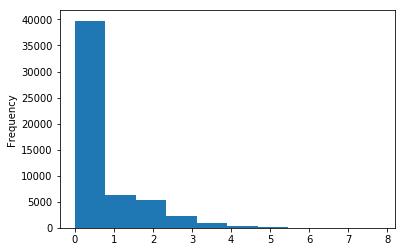

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [6]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


Let's fill-in the missing values for reviewText below. We will just use the placeholder "Missing" here.

In [7]:
df["reviewText"].fillna("Missing", inplace=True)

### 3. Stop Word Removal and Stemming

In [8]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list. It is because those words are actually useful to understand the sentiment in the sentence.

In [9]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [10]:
print("Pre-processing the reviewText field")
df["reviewText"] = process_text(df["reviewText"].tolist())

Pre-processing the reviewText field


### 4. Scaling numerical fields:

We will apply min-max scaling to our rating field so that they will be between 0-1.

In [11]:
df["rating"] = (df["rating"] - df["rating"].min())/(df["rating"].max()-df["rating"].min())
df["time"] = (df["time"] - df["time"].min())/(df["time"].max()-df["time"].min())

### 5. Splitting the training dataset into training, validation and test

Sklearn library has a useful function to split datasets. We will use the __train_test_split()__ function. In the example below, we get 80% for training, 10% for validation and 10% for test.

In [12]:
from sklearn.model_selection import train_test_split

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df[["reviewText",
                                                      "rating",
                                                      "time"]],
                                                  df["log_votes"].tolist(),
                                                  test_size=0.20,
                                                  shuffle=True)

X_test, X_val, y_test, y_val = train_test_split(X_val,
                                                y_val,
                                                test_size=0.50,
                                                shuffle=True)

### 6. Computing Bag of Words Features

We are using binary features here. TF and TF-IDF are also other options.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the binary count vectorizer
tfidf_vectorizer = CountVectorizer(binary=True,     # using binary features
                                   max_features=50  # vocabulary limit
                                  )
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["reviewText"].tolist())
# Only transform
X_test_text_vectors = tfidf_vectorizer.transform(X_test["reviewText"].tolist())

Let's print our vocabulary below. The number next to the word is its index in the vocabulary.

In [14]:
print(tfidf_vectorizer.vocabulary_)

{'product': 27, 'price': 25, 'purchas': 29, 'upgrad': 38, 'program': 28, 'need': 21, 'version': 42, 'use': 39, 'work': 47, 'time': 36, 'new': 22, 'good': 12, 'well': 45, 'problem': 26, 'file': 9, 'much': 20, 'like': 16, 'also': 0, 'get': 11, 'softwar': 33, 'help': 14, 'look': 17, 'one': 24, 'would': 48, 'not': 23, 'instal': 15, 'window': 46, 'comput': 4, 'support': 35, 'way': 44, 'make': 18, 'tri': 37, 'back': 1, 'could': 5, 'still': 34, 'great': 13, 'year': 49, 've': 41, 'realli': 30, 'want': 43, 'buy': 3, 'better': 2, 'easi': 7, 'recommend': 31, 'user': 40, 'even': 8, 'download': 6, 'mani': 19, 'run': 32, 'find': 10}


### 7. Training with Sagemaker


We will call the Sagemaker `LinearLearner()` below. 
* __Compute power:__ We will use `train_instance_count` and `train_instance_type` parameters. This example uses `ml.m4.xlarge` resource for training. We can change the instance type for our needs (For example GPUs for neural networks). 
* __Model type:__ `predictor_type` is set to __'regressor'__ as we have a regression problem. For classification, we can choose between `binary_classifier` and `multiclass_classifier`.

In [15]:
import sagemaker

# Call the LinearLearner estimator object
linear_regressor = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                           train_instance_count=1,
                                           train_instance_type='ml.m4.xlarge',
                                           predictor_type='regressor')

We are using the `record_set()` function of our binary_estimator to set the training, validation, test parts of the estimator. 

In [16]:
import numpy as np

# Let's merge our training features
train_features = np.column_stack((X_train_text_vectors.toarray(),
                                  X_train["rating"].values,
                                  X_train["time"].values)).astype("float32")
# Let's merge our val features
val_features = np.column_stack((X_val_text_vectors.toarray(),
                                X_val["rating"].values,
                                X_val["time"].values)).astype("float32")
# Let's merge our test features
test_features = np.column_stack((X_test_text_vectors.toarray(),
                                 X_test["rating"].values,
                                 X_test["time"].values)).astype("float32")

train_records = linear_regressor.record_set(train_features,
                                            np.array(y_train).astype("float32"),
                                            channel='train')
val_records = linear_regressor.record_set(val_features,
                                          np.array(y_val).astype("float32"),
                                          channel='validation')
test_records = linear_regressor.record_set(test_features,
                                           np.array(y_test).astype("float32"),
                                           channel='test')

`fit()` function applies a distributed version of the Stochastic Gradient Descent (SGD) algorithm and we are sending the data to it. We disabled logs with `logs=False`. You can remove that parameter to see more details about the process. __This process takes about 3-4 minutes on a ml.m4.xlarge instance.__

In [17]:
linear_regressor.fit([train_records, val_records, test_records], logs=False)


2020-02-19 19:38:16 Starting - Starting the training job
2020-02-19 19:38:17 Starting - Launching requested ML instances..........
2020-02-19 19:39:15 Starting - Preparing the instances for training...........
2020-02-19 19:40:13 Downloading - Downloading input data......
2020-02-19 19:40:48 Training - Downloading the training image...
2020-02-19 19:41:07 Training - Training image download completed. Training in progress...
2020-02-19 19:41:23 Uploading - Uploading generated training model
2020-02-19 19:41:30 Completed - Training job completed


### 8. Model Evaluation

In this section, we will look at how our model performs with our test dataset. 

### Sagemaker Analytics
We can use Sagemaker analytics to get some performance metrics of our choice. This doesn't require us to deploy our model. Since this is a regression problem, we can check the mean squared error and absolute loss (mean absolute error).
\begin{align}
MSE=\frac{1}{n}\sum_{examples}{(y-p)^2}
\tag{1}
\end{align}

\begin{align}
MAE=\frac{1}{n}\sum_{examples}{|y-p|}
\tag{2}
\end{align}

In [18]:
sagemaker.analytics.TrainingJobAnalytics(linear_regressor._current_job_name, 
                                         metric_names = ['test:mse', 'test:absolute_loss']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,test:mse,0.637318
1,0.0,test:absolute_loss,0.561274


### 9. Deploying the model and using the endpoint

In the last part of this exercise, we will deploy our model to another instance of our choice. This will allow us to use this model in production environment. Deployed endpoints can be used with other AWS Services such as Lambda and API Gateway. A nice walkthrough is available here: https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/ if you are interested.

__9.1 Deploy the model:__

Run the following cell to deploy the model. We can use different instance types such as: `ml.m4.4xlarge`, `ml.c4.xlarge` etc. In this example, we will deploy the model locally. __This will take some time to complete (Approximately 7-8 minutes).__

In [19]:
linear_regressor_predictor = linear_regressor.deploy(initial_instance_count = 1,
                                                     instance_type = 'local',
                                                     endpoint_name = 'LinearLearnerEndpoint'
                                                    )

---------------!

__9.2 Test the endpoint:__

Let's use the deployed endpoint. We will send our test data and get predictions of it.

In [20]:
# Let's get test data in batch size of 25 and make predictions.
prediction_batches = [linear_regressor_predictor.predict(batch) for batch in np.array_split(test_features, 25)]

# Let's get a list of predictions
print([pred.label['score'].float32_tensor.values[0] for pred in prediction_batches[0]])

[0.8279767632484436, 0.6629393100738525, 0.35181522369384766, 1.5366345643997192, -0.13714396953582764, -0.0277479887008667, 0.063149094581604, 0.8387523889541626, 0.35605406761169434, 0.17237985134124756, 0.5513490438461304, 0.45017755031585693, 0.4606703519821167, 0.24959397315979004, -0.002505064010620117, 0.24075961112976074, 1.2099015712738037, 1.6727807521820068, 0.14436662197113037, -0.07796716690063477, 0.3116481304168701, -0.10095643997192383, 0.8224915862083435, 0.6056076288223267, 0.3705000877380371, 0.32202231884002686, 0.43273091316223145, -0.09249341487884521, 1.826664924621582, 0.014580011367797852, -0.24821841716766357, 0.019512534141540527, 0.2442265748977661, 1.4100759029388428, 0.8938725590705872, 0.8287944793701172, 0.2007378339767456, 0.03726840019226074, -0.007052898406982422, 0.10569262504577637, 0.12165224552154541, 0.1431901454925537, -0.07442605495452881, 0.8697413206100464, 0.614319920539856, 0.8596420884132385, 1.2634344100952148, -0.027432918548583984, 0.42

You can run the following to delete the endpoint after you are done using it.

In [21]:
# sagemaker_session = sagemaker.Session()
# sagemaker_session.delete_endpoint(linear_regressor_predictor.endpoint)